In [1]:
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt

In [2]:
polls = pd.read_csv('president_polls.csv')

In [3]:
polls.columns

Index(['poll_id', 'pollster_id', 'pollster', 'sponsor_ids', 'sponsors',
       'display_name', 'pollster_rating_id', 'pollster_rating_name',
       'numeric_grade', 'pollscore', 'methodology', 'transparency_score',
       'state', 'start_date', 'end_date', 'sponsor_candidate_id',
       'sponsor_candidate', 'sponsor_candidate_party', 'endorsed_candidate_id',
       'endorsed_candidate_name', 'endorsed_candidate_party', 'question_id',
       'sample_size', 'population', 'subpopulation', 'population_full',
       'tracking', 'created_at', 'notes', 'url', 'url_article', 'url_topline',
       'url_crosstab', 'source', 'internal', 'partisan', 'race_id', 'cycle',
       'office_type', 'seat_number', 'seat_name', 'election_date', 'stage',
       'nationwide_batch', 'ranked_choice_reallocated', 'ranked_choice_round',
       'hypothetical', 'party', 'answer', 'candidate_id', 'candidate_name',
       'pct'],
      dtype='object')

First we filter out any older than October 15th. The dates are not stored in ISO form so rewrite them

In [4]:
polls['start'] = [datetime.strptime(d, "%m/%d/%y").strftime('%Y/%m/%d') for d in polls.start_date]
polls['end'] = [datetime.strptime(d, "%m/%d/%y").strftime('%Y/%m/%d') for d in polls.end_date]

In [5]:
recent = polls[polls.start > '2024/10/15']

Then we find the polls we have a decent number of

In [6]:
n_by_state = recent.groupby('state').poll_id.nunique()
n_by_state[n_by_state > 20]

state
Arizona           30
Georgia           23
Michigan          37
Nevada            21
North Carolina    27
Pennsylvania      39
Wisconsin         32
Name: poll_id, dtype: int64

Arizona and Nevada still have a significant number of ballots to count, so we will focus on the other ones

In [7]:
states = ['Georgia', 'Michigan', 'North Carolina', 'Pennsylvania', 'Wisconsin']
data = recent[recent.state.isin(states)]

Also we can restrict to likely voters

In [8]:
data = data[data.population == 'lv']

Get the data for each candidate we care about (sorry Chase and Jill)

In [9]:
trump_data = data[data.candidate_id == 16651]
harris_data = data[data.candidate_id == 16661]

We will use the max percentage for each poll, as that should represent the head to head result

In [10]:
margin = trump_data.groupby('poll_id').pct.max() - harris_data.groupby('poll_id').pct.max()

Just a sanity check

In [11]:
by_poll = data.groupby('poll_id')

In [12]:
for col in ['state', 'sample_size', 'start_date', 'race_id', 'url_topline']:
    max(by_poll[col].nunique())

In [13]:
poll_data = pd.DataFrame({'margin': margin, 
                          'state': by_poll.state.first(), 
                          'sample_size': by_poll.sample_size.first(), 
                          'url': by_poll.url_topline.first()}).dropna()

In [14]:
results = {"Georgia": 2.2, "Michigan": 1.4, "North Carolina": 3.3, "Pennsylvania": 2, "Wisconsin": 0.8}
turnouts = {"Georgia": 5247095, "Michigan": 5653664, "North Carolina": 5639974, "Pennsylvania": 6958777, "Wisconsin": 3420185}


In [15]:
poll_data["result"] = [results[state] for state in poll_data.state]
poll_data["turnout"] = [turnouts[state] for state in poll_data.state]

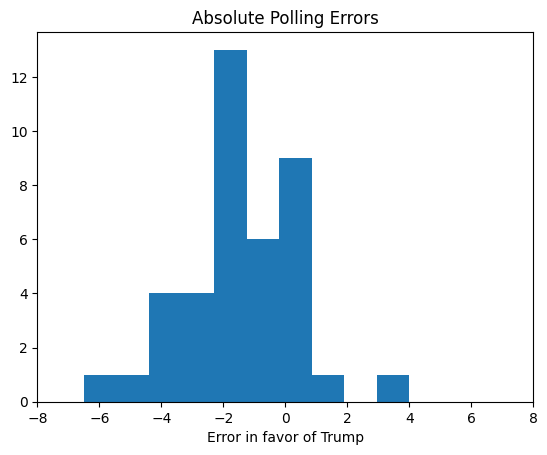

In [16]:
plt.hist(poll_data.margin - poll_data.result)
plt.title("Absolute Polling Errors")
plt.xlabel("Error in favor of Trump")
plt.xlim(-8, 8)
plt.show()

The data does not include the margins of error, so I had to manually look them up. For a handful I could not easily find them, so I am excluding them.

In [17]:
moes = {
 88807: 2.9,
 88836: 3.03,
 88844: 2.9,
 88845: 2.9,
 88942: 4,
 88967: 2.9,
 88974: None,
 88992: 4, 
 88994: 4,
 89017: 4.9,
 89025: 3.46,
 89029: 2.9,
 89065: 3.4,
 89082: None,
 89102: 4.38,
 89103: None,
 89109: 2.5,
 89110: 2.5,
 89113: 3,
 89120: 3.7,
 89130: 3.8,
 89135: 3.4,
 89137: 3.5,
 89138: 4.4,
 89139: 4.5,
 89156: None,
 89163: 4,
 89197: 3.1,
 89271: 4.1,
 89272: 3.6,
 89274: 3.7,
 89275: 2.9,
 89276: 3.4,
 89306: 2.9,
 89314: 2.9,
 89315: 2.9,
 89343: None,
 89345: 3.6,
 89346: 3.5,
 89347: 3.6
}

In [18]:
for poll in poll_data.index:
    print(f"{poll}: {poll_data.loc[poll].state}, {poll_data.loc[poll].url}")

88807: Pennsylvania, https://www.thetrafalgargroup.org/wp-content/uploads/2024/10/PA-24-General-1020-Poll-Report.pdf
88836: Pennsylvania, https://docs.google.com/document/d/1EUb3A_M9KbY91NMY-szLiOD6XmXTlY-w/edit
88844: Wisconsin, https://www.thetrafalgargroup.org/wp-content/uploads/2024/10/WI-Gen-Pres-Report-1021.pdf
88845: Michigan, https://www.thetrafalgargroup.org/wp-content/uploads/2024/10/MI-Gen-Pres-Poll-Report-1021.pdf
88942: Wisconsin, https://senopportunity.org/wp-content/uploads/2024/10/2024-10-SOF-Battground-Polling-NV-OH-WI-Deck.pdf
88967: Georgia, https://www.thetrafalgargroup.org/wp-content/uploads/2024/10/GA-24-General-1027_Report.pdf
88974: Wisconsin, https://www.suffolk.edu/-/media/suffolk/documents/academics/research-at-suffolk/suprc/polls/other-states/2024/10_28_2024_wisconsin_statewide_marginals.pdf
88992: Pennsylvania, https://cdn.amgreatness.com/app/uploads/2024/10/PA-October-Toplines.pdf
88994: Michigan, https://s3.documentcloud.org/documents/25260347/late-octobe

In [19]:
poll_data['moe'] = [moes[poll] for poll in poll_data.index]
poll_data = poll_data.dropna()

In [20]:
scaled_errors = (poll_data.margin - poll_data.result)/2/poll_data.moe

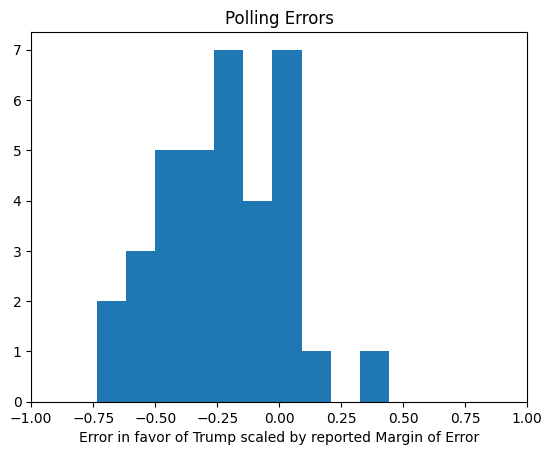

In [21]:
plt.hist(scaled_errors)
plt.title("Polling Errors")
plt.xlabel("Error in favor of Trump scaled by reported Margin of Error")
plt.xlim(-1,1)
plt.show()

In [25]:
poll_data.loc[89017].url

'https://x.com/SusquehannaPR/status/1851266619445571914'